### Recyclability Classifier, based on Google's Mobilenetv3 Model


In [1]:
from utils import *
from tensorflow import keras

# Load dataset
df_dataset = load_from_pickle(dataset_file)
# Take 10% of stratified samples for zero-shot classification testing
_x_train, zs_x, _y_train, zs_y = train_test_split(df_dataset['File'], df_dataset['Material Class'], test_size=0.1, stratify=df_dataset['Material Class'], random_state=9876)
# 80-20 Train-Test split
x_train, x_test, y_train, y_test = train_test_split(df_dataset['File'], df_dataset['Material Class'], test_size=0.2, stratify=df_dataset['Material Class'], random_state=1234)

In [2]:
""" Dataset Preparations """
# Parameters
img_batch_size = 32
img_height = 160
img_width = 160
img_size = (img_height, img_width)
img_shape = img_size + (3,)

# Training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
  DATASET_FOLDER,
  validation_split=0.2,
  subset="training",
  shuffle=True,
  seed=19032024,
  image_size=(img_height, img_width),
  batch_size=img_batch_size)

# Validation (test) dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
  DATASET_FOLDER,
  validation_split=0.2,
  subset="validation",
  shuffle=True,
  seed=19032024,
  image_size=(img_height, img_width),
  batch_size=img_batch_size)

# Get class names
class_names = train_ds.class_names
class_names = val_ds.class_names

# Enable buffered prefetching to overlap data preprocessing and model execution during training, to speed up access to dataset
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

# Normalise image tensors' RGB channel values from [0, 255] to required [-1, 1] values used by Mobilenet (use preprocess_input function provided by the model instead!)
# normalization_layer = tf.keras.layers.Rescaling(1./127.5, offset=-1)
# normalized_train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
# normalized_val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

# Preview datasets
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Found 24235 files belonging to 5 classes.
Using 19388 files for training.
Found 24235 files belonging to 5 classes.
Using 4847 files for validation.


In [8]:
# Initialise base model
base_model = tf.keras.applications.MobileNetV3Small(input_shape=img_shape, include_top=False, weights='imagenet')

# Freeze base model
base_model.trainable = False

""" Create classification head """
# Create NN layers
data_augmentation = tf.keras.Sequential([tf.keras.layers.RandomFlip('horizontal'),tf.keras.layers.RandomRotation(0.2),tf.keras.layers.RandomZoom(0.2)])
preprocess_input = tf.keras.applications.mobilenet_v3.preprocess_input
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

# Create classifier
inputs = keras.Input(shape=img_shape)

# Preprocessing layers
x = data_augmentation(inputs)
x = preprocess_input(x)

# Base model layer, ensure that the model is running in inference mode
x = base_model(x, training=False) 

# Processing layers
x = global_average_layer(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.3)(x) # Dropout regularisation to prevent overfitting

# Dense classifier layer for multi-label classification
outputs = keras.layers.Dense(len(class_names), activation='softmax')(x)

# Create classification head
model = keras.Model(inputs, outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [13]:
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobilenetV3small (Functional)   │ (None, 5, 5, 576)      │       939,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 576)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024)           │       590,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,108,981 (11.86 MB)

 Trainable params: 2,168,837 (8.27 MB)

 Non-trainable params: 940,144 (3.59 MB)

In [14]:
# Train model
history = model.fit( train_ds, validation_data=val_ds, epochs=10)

Epoch 1/10
606/606 ━━━━━━━━━━━━━━━━━━━━ 107s 170ms/step - accuracy: 0.7339 - loss: 0.7526 - val_accuracy: 0.8446 - val_loss: 0.4366
Epoch 2/10
606/606 ━━━━━━━━━━━━━━━━━━━━ 104s 170ms/step - accuracy: 0.8535 - loss: 0.4125 - val_accuracy: 0.8770 - val_loss: 0.3241
Epoch 3/10
606/606 ━━━━━━━━━━━━━━━━━━━━ 104s 170ms/step - accuracy: 0.8850 - loss: 0.3347 - val_accuracy: 0.8911 - val_loss: 0.3003
Epoch 4/10
606/606 ━━━━━━━━━━━━━━━━━━━━ 104s 170ms/step - accuracy: 0.8988 - loss: 0.2837 - val_accuracy: 0.8845 - val_loss: 0.3300
Epoch 5/10
606/606 ━━━━━━━━━━━━━━━━━━━━ 105s 171ms/step - accuracy: 0.9126 - loss: 0.2475 - val_accuracy: 0.9030 - val_loss: 0.2955
Epoch 6/10
606/606 ━━━━━━━━━━━━━━━━━━━━ 106s 173ms/step - accuracy: 0.9202 - loss: 0.2292 - val_accuracy: 0.9098 - val_loss: 0.2703
Epoch 7/10
606/606 ━━━━━━━━━━━━━━━━━━━━ 109s 178ms/step - accuracy: 0.9287 - loss: 0.2076 - val_accuracy: 0.9133 - val_loss: 0.2466
Epoch 8/10
606/606 ━━━━━━━━━━━━━━━━━━━━ 104s 169ms/step - accuracy: 0.9365 -

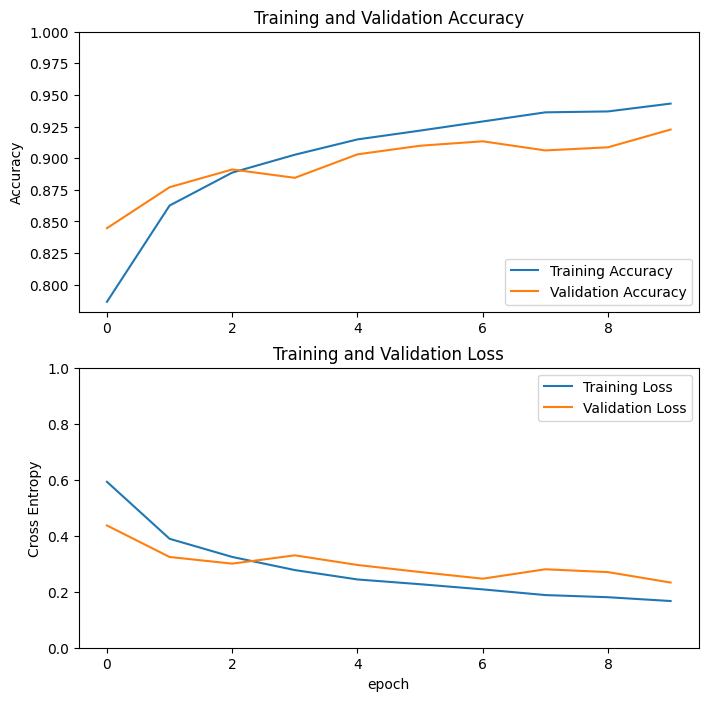

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [16]:
loss, accuracy = model.evaluate(val_ds)
print('Test accuracy :', accuracy)

152/152 ━━━━━━━━━━━━━━━━━━━━ 21s 133ms/step - accuracy: 0.9207 - loss: 0.2372
Test accuracy : 0.9226325750350952


Predictions:
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1]
Labels:
 [3 0 4 2 2 1 3 2 0 1 2 2 1 1 3 3 2 3 2 3 3 4 0 2 2 3 3 0 2 4 3 4]


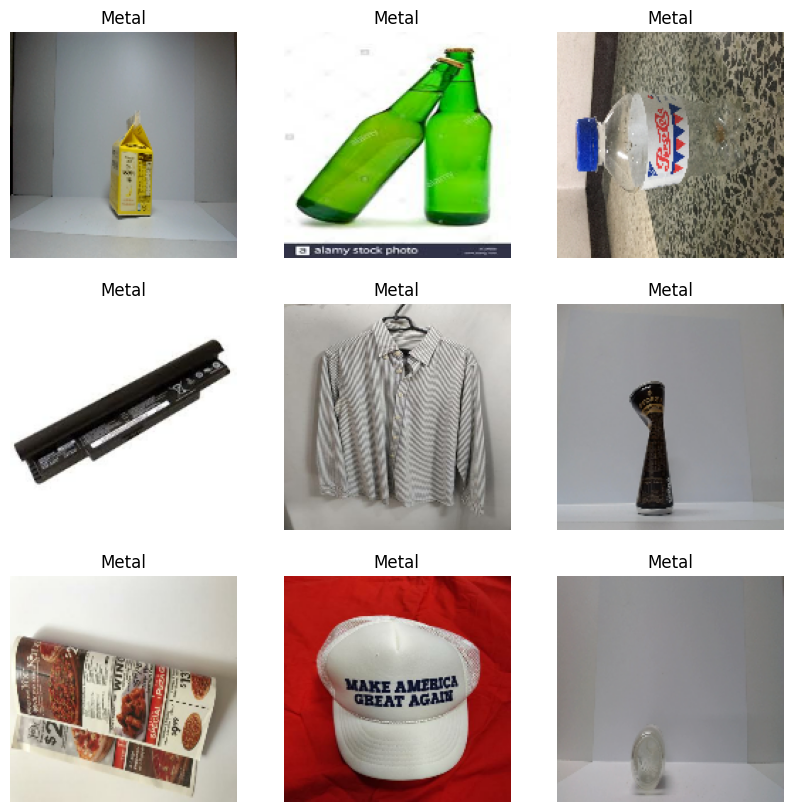

In [19]:
# Retrieve a batch of images from the test set
image_batch, label_batch = val_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [ ]:
# Export model
model.save(model_file)

# Import model
model = keras.models.load_model(model_file)

#### References
- https://blog.research.google/2019/11/introducing-next-generation-on-device.html
- https://www.kaggle.com/models/google/mobilenet-v3/frameworks/tensorFlow2
- https://www.tensorflow.org/tutorials/images/transfer_learning
- https://www.tensorflow.org/tutorials/load_data/images
- https://github.com/CHOOSLA/Recycle_Classification_MobileNetV3